Solution status: optimal
Maximum concurrent flow: 0.7500

Session 0: 0 → 2 (flow: 0.7500)
  Path: 0 → 3 → 2, Flow: 0.3750
  Path: 0 → 4 → 2, Flow: 0.3750
  Total session flow: 0.7500

Session 1: 1 → 0 (flow: 0.7500)
  Total session flow: 0.0000

Session 2: 2 → 1 (flow: 0.7500)
  Total session flow: 0.0000

Session 3: 3 → 4 (flow: 0.7500)
  Total session flow: 0.0000


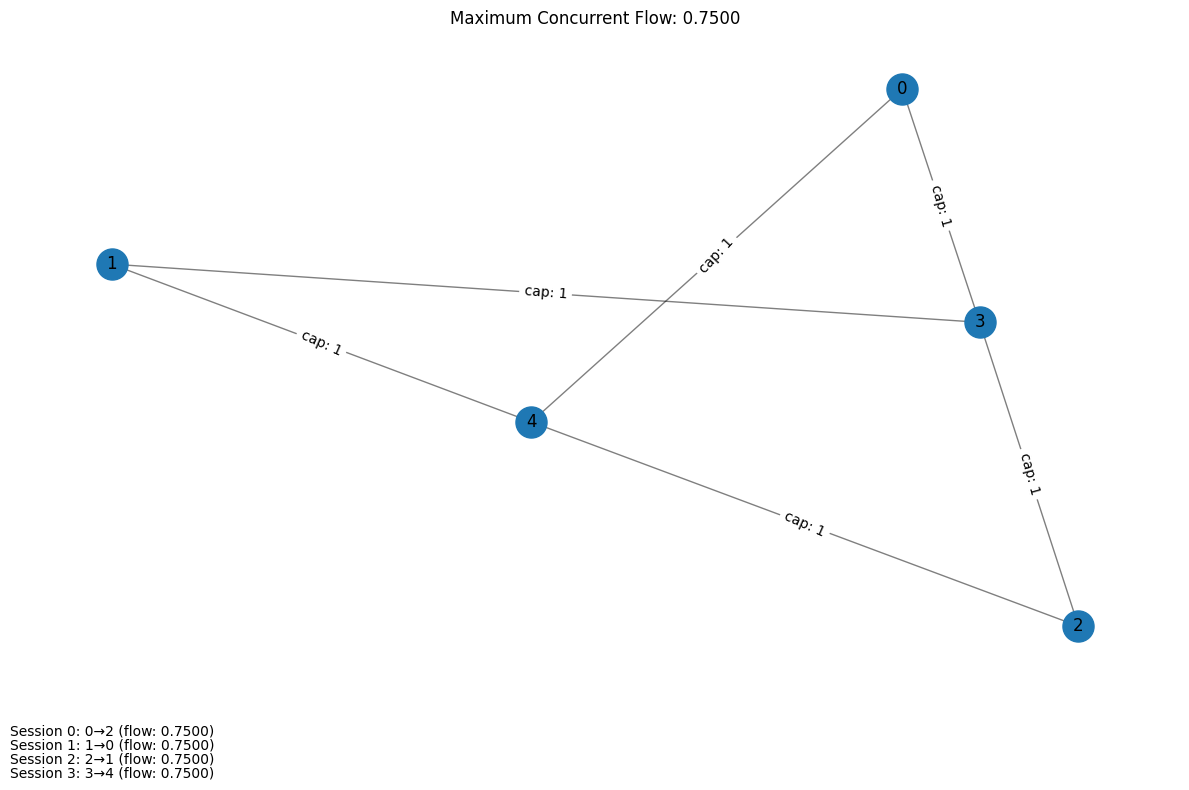

/var/folders/hz/773t5b8x1t9_5wdc9ywdn3pm0000gn/T/ipykernel_90442/578063953.py:251: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


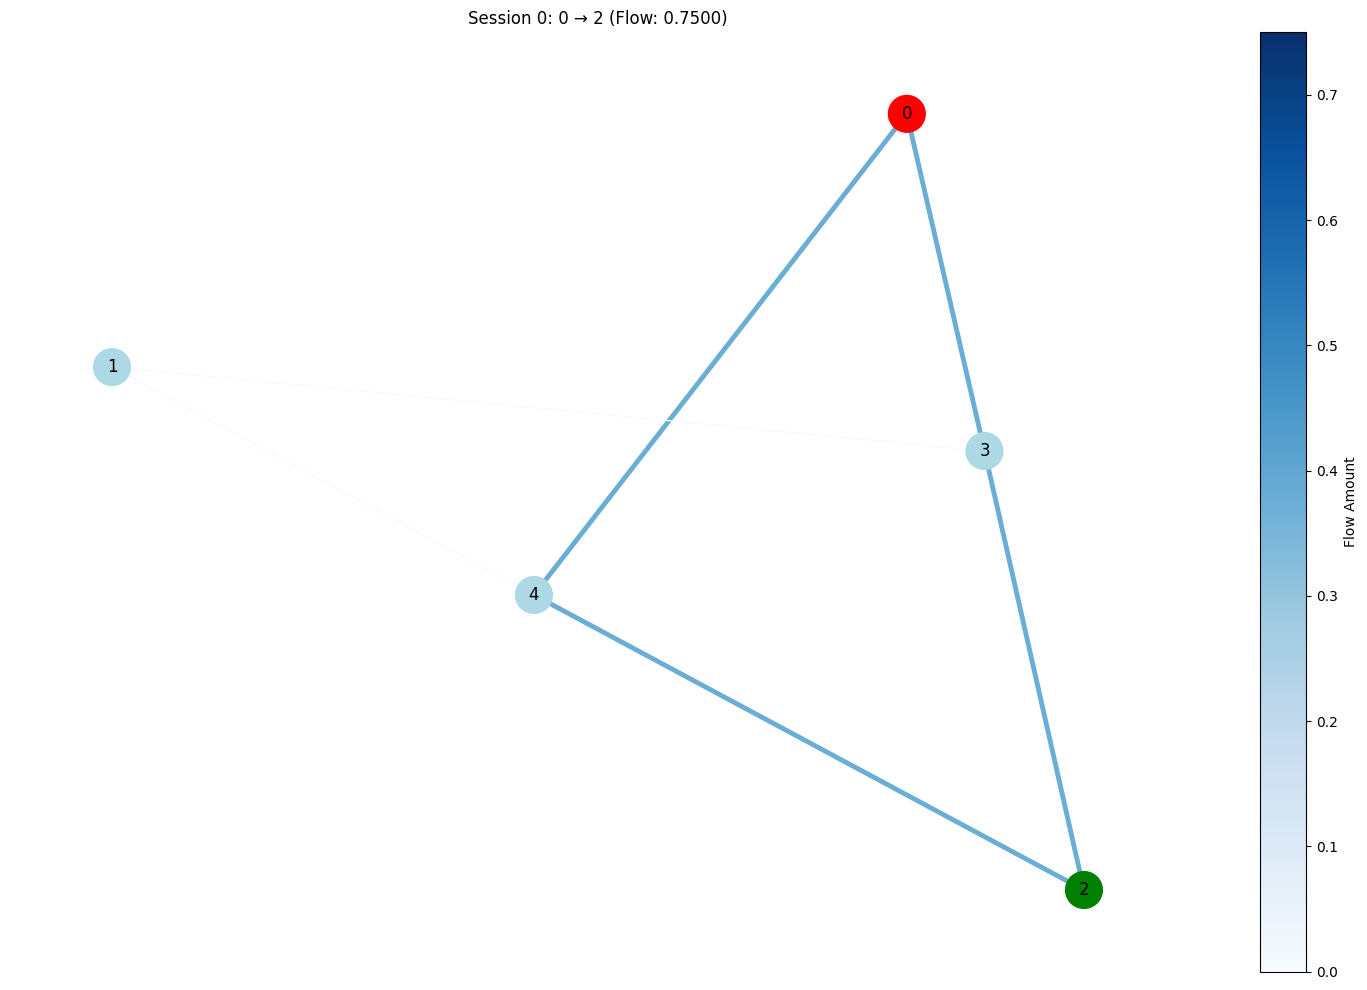

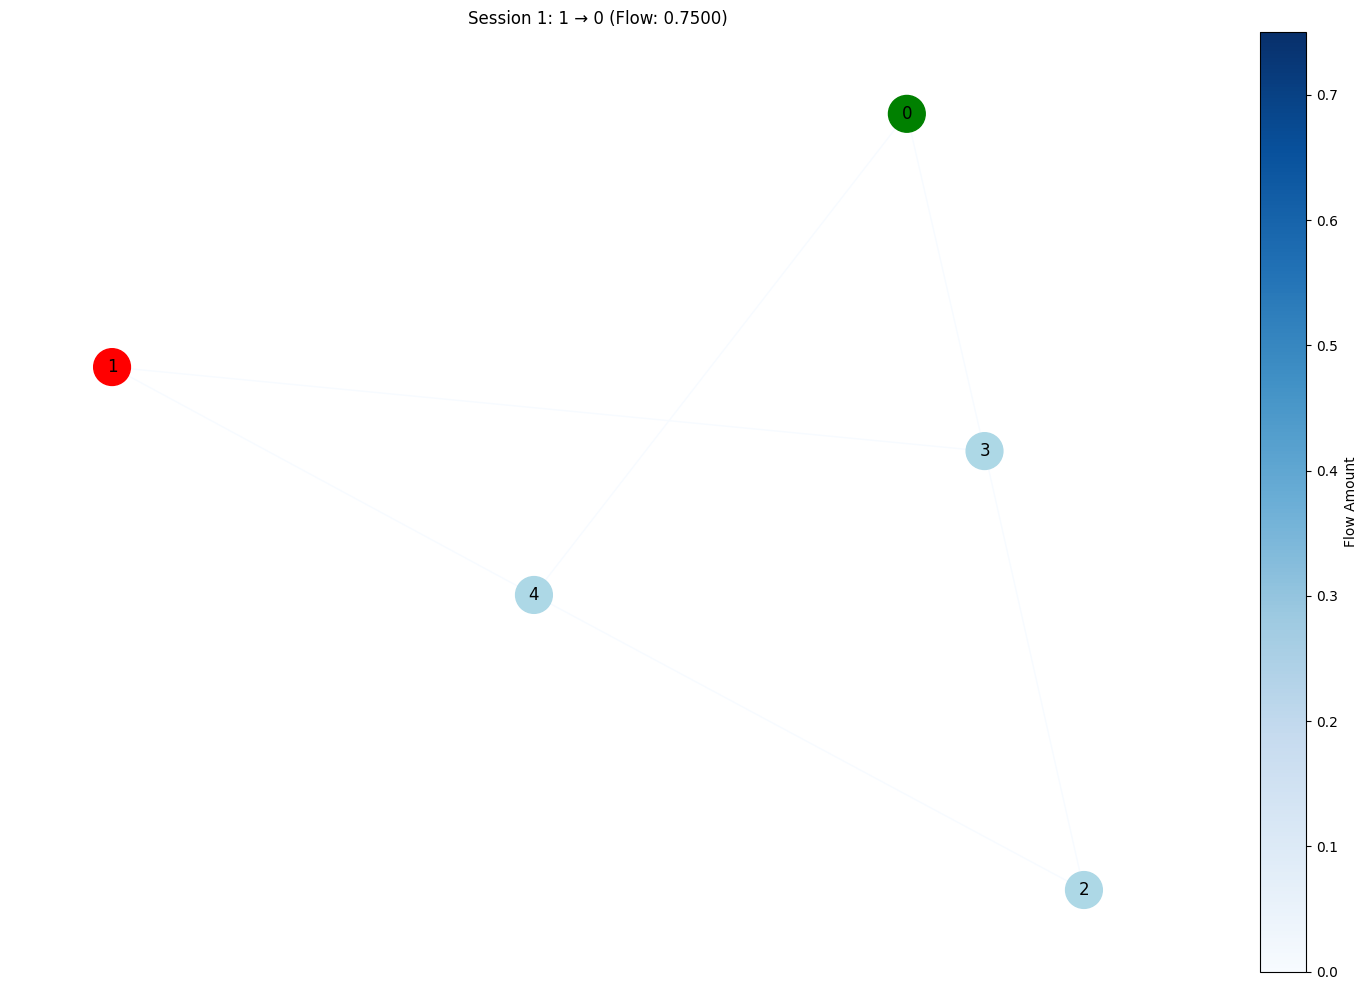

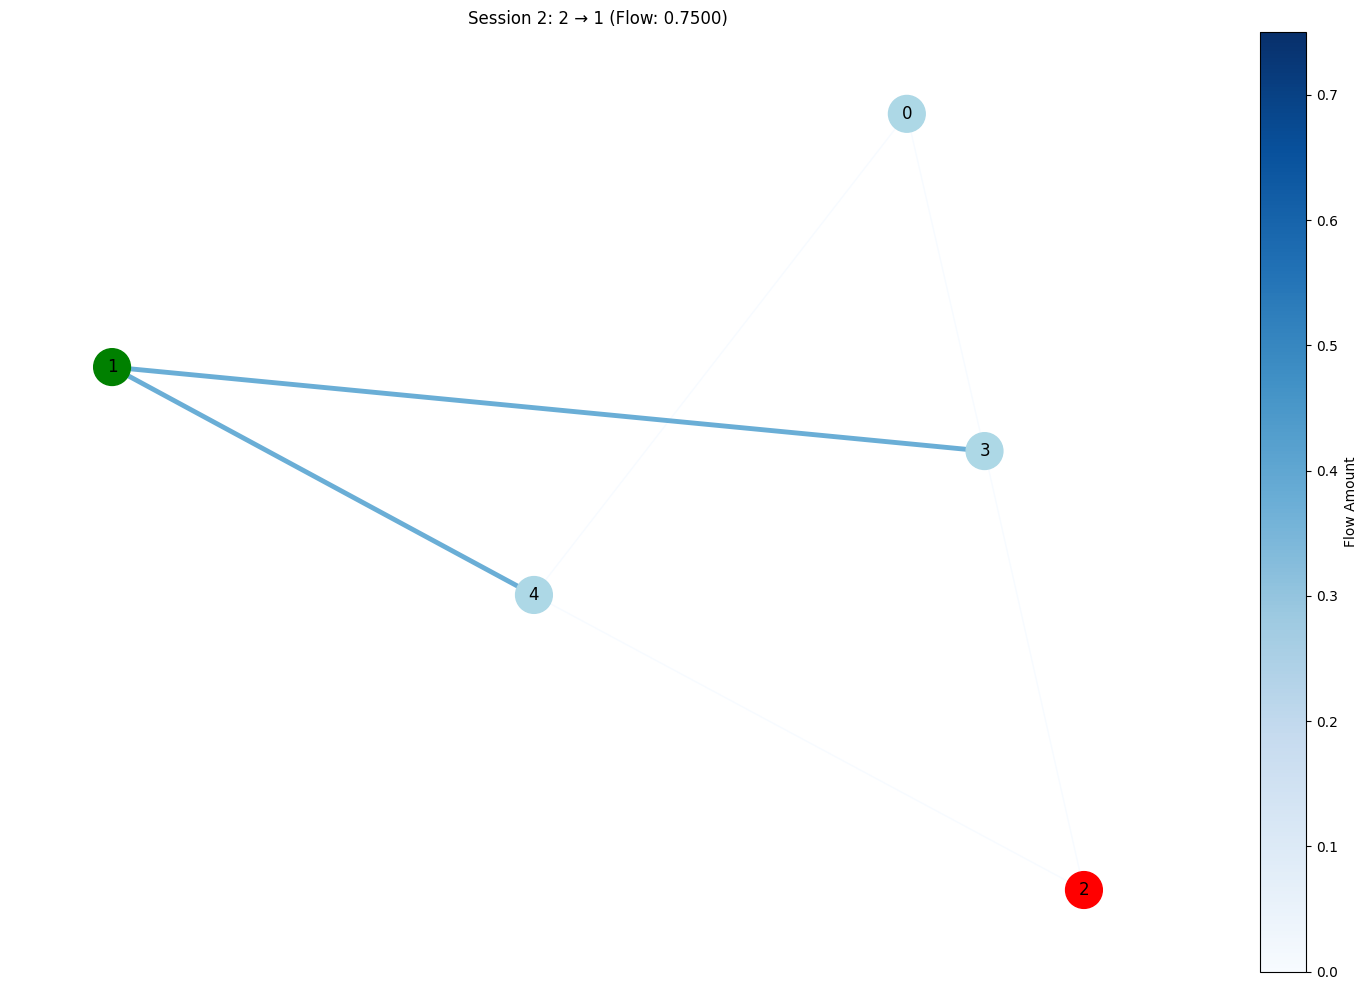

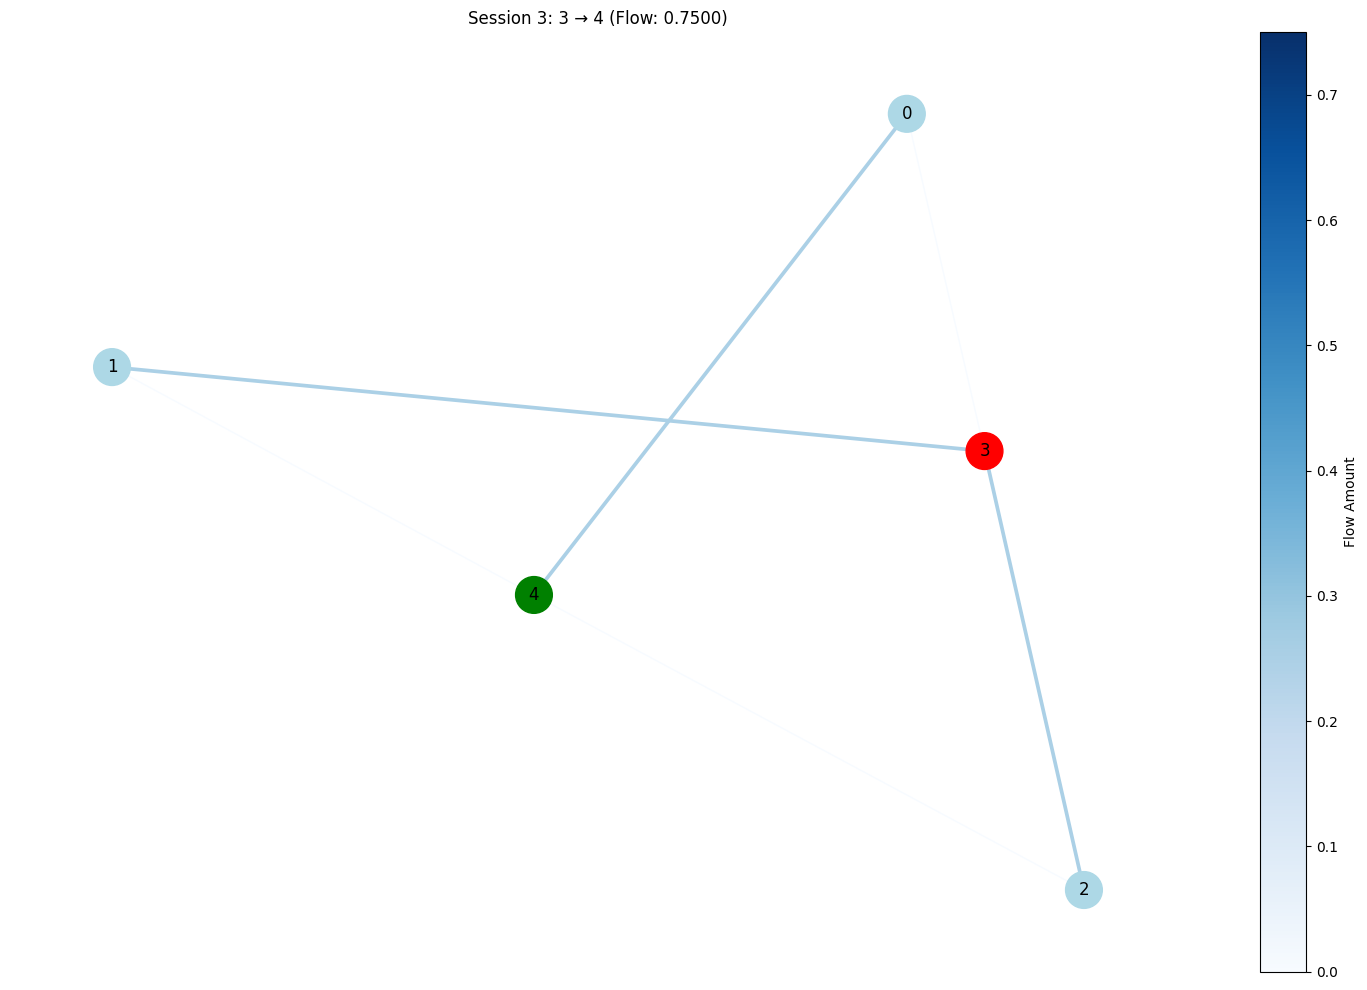

In [6]:
import networkx as nx
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict


class MaxConcurrentFlowSolver:
    """
    Solver for maximum concurrent flow problems in undirected networks.
    Finds the maximum flow that all sessions can achieve simultaneously.
    """
    
    def __init__(self, G: nx.Graph, sessions: List[Tuple[int, int]]):
        """
        Initialize the solver with a network and sessions.
        
        Args:
            G: NetworkX undirected graph with edge capacities stored as 'capacity' attribute
            sessions: List of (source, target) tuples representing commodity flows
        """
        self.G = G.copy()
        self.sessions = sessions
        self.num_nodes = G.number_of_nodes()
        self.num_edges = G.number_of_edges()
        self.num_commodities = len(sessions)
        
        # Store edges in a consistent order
        self.edges = list(G.edges())
        self.edge_index = {e: i for i, e in enumerate(self.edges)}
        
        # Add reverse edges to the edge index for undirected graph
        for (u, v) in list(self.edge_index.keys()):
            self.edge_index[(v, u)] = self.edge_index[(u, v)]
        
        # Extract edge capacities
        self.capacities = np.array([G[u][v].get('capacity', float('inf')) for u, v in self.edges])
        
        # Initialize results
        self.flows = None
        self.max_concurrent_flow = None
        self.status = None
    
    def solve(self):
        """
        Solve the maximum concurrent flow problem using linear programming.
        
        Returns:
            Dict containing solution status and optimal flows
        """
        # Create flow variables for each commodity on each edge
        # f[k][i][j] represents flow of commodity k on edge (i,j)
        f = {}
        for k in range(self.num_commodities):
            f[k] = {}
            for i in range(self.num_nodes):
                f[k][i] = {}
                for j in range(self.num_nodes):
                    if self.G.has_edge(i, j):
                        f[k][i][j] = cp.Variable(nonneg=True)
        
        # Create variable for the maximum concurrent flow
        # This represents how much flow each session can carry
        mcf = cp.Variable(nonneg=True)
        
        # Objective: Maximize the concurrent flow
        objective = cp.Maximize(mcf)
        
        # Constraints
        constraints = []
        
        # 1. Capacity constraints for each edge (sum of all commodity flows <= edge capacity)
        for u, v in self.edges:
            edge_flow_sum = 0
            for k in range(self.num_commodities):
                edge_flow_sum += f[k][u][v] + f[k][v][u]  # Sum both directions for undirected
            constraints.append(edge_flow_sum <= self.G[u][v].get('capacity', float('inf')))
        
        # 2. Flow conservation constraints
        for k, (source, target) in enumerate(self.sessions):
            for i in range(self.num_nodes):
                if i != source and i != target:  # For intermediate nodes
                    # Sum of incoming flows equals sum of outgoing flows
                    flow_balance = 0
                    for j in self.G.neighbors(i):
                        flow_balance += f[k][j][i] - f[k][i][j]
                    constraints.append(flow_balance == 0)
        
        # 3. Flow requirements - each session must achieve the mcf value
        for k, (source, target) in enumerate(self.sessions):
            # Calculate the net outflow at source
            source_outflow = 0
            for j in self.G.neighbors(source):
                source_outflow += f[k][source][j] - f[k][j][source]
            constraints.append(source_outflow == mcf)
            
            # The net inflow at target should equal the outflow at source
            target_inflow = 0
            for i in self.G.neighbors(target):
                target_inflow += f[k][i][target] - f[k][target][i]
            constraints.append(target_inflow == mcf)
        
        # Solve the problem
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.ECOS)
        
        # Store results
        self.status = problem.status
        self.max_concurrent_flow = mcf.value
        
        # Extract flow values for each commodity on each edge
        self.flows = {}
        for k in range(self.num_commodities):
            self.flows[k] = {}
            for u, v in self.edges:
                self.flows[k][(u, v)] = f[k][u][v].value
        
        return {
            'status': self.status,
            'max_concurrent_flow': self.max_concurrent_flow,
            'flows': self.flows
        }
    
    def get_flow_dict(self) -> Dict:
        """
        Returns a dictionary of flows for each session and edge.
        
        Returns:
            Dict: {session_idx: {(u, v): flow_value}}
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before getting flows")
        return self.flows
    
    def visualize_network(self, figsize=(12, 8)):
        """
        Visualize the network with edge capacities and optimal flows.
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before visualization")
        
        plt.figure(figsize=figsize)
        
        # Create position layout
        pos = nx.spring_layout(self.G, seed=42)
        
        # Draw nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=500)
        
        # Draw edges with capacity labels
        edge_labels = {(u, v): f"cap: {self.G[u][v].get('capacity', '∞')}" for u, v in self.edges}
        nx.draw_networkx_edges(self.G, pos, width=1.0, alpha=0.5)
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)
        
        # Draw node labels
        nx.draw_networkx_labels(self.G, pos)
        
        # Add source and target information
        for k, (source, target) in enumerate(self.sessions):
            plt.annotate(f"Session {k}: {source}→{target} (flow: {self.max_concurrent_flow:.4f})",
                        xy=(0, 0), xytext=(0, -30 - 10 * k),
                        xycoords=('axes fraction'), textcoords='offset points',
                        ha='left', va='top')
        
        plt.title(f"Maximum Concurrent Flow: {self.max_concurrent_flow:.4f}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def print_solution(self):
        """
        Print the solution details.
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before printing solution")
        
        print(f"Solution status: {self.status}")
        print(f"Maximum concurrent flow: {self.max_concurrent_flow:.4f}")
        
        for k, (source, target) in enumerate(self.sessions):
            print(f"\nSession {k}: {source} → {target} (flow: {self.max_concurrent_flow:.4f})")
            
            # Find all paths with positive flow for this session
            paths = []
            visited = set()
            
            def find_paths(node, path, remaining_flow):
                if node == target and remaining_flow > 1e-6:
                    paths.append((path[:], remaining_flow))
                    return
                
                visited.add(node)
                for neighbor in self.G.neighbors(node):
                    edge = (node, neighbor)
                    flow = self.flows[k].get(edge, 0)
                    if flow > 1e-6 and neighbor not in visited:
                        path.append(neighbor)
                        find_paths(neighbor, path, min(remaining_flow, flow))
                        path.pop()
                visited.remove(node)
            
            # Start DFS from source
            find_paths(source, [source], float('inf'))
            
            # Print paths
            total_session_flow = 0
            for path, flow in paths:
                print(f"  Path: {' → '.join(map(str, path))}, Flow: {flow:.4f}")
                total_session_flow += flow
            
            print(f"  Total session flow: {total_session_flow:.4f}")
    
    def visualize_flows(self, figsize=(15, 10)):
        """
        Visualize the network with flows for each session.
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before visualization")
        
        # Create a separate visualization for each session
        for k, (source, target) in enumerate(self.sessions):
            plt.figure(figsize=figsize)
            pos = nx.spring_layout(self.G, seed=42)
            
            # Create edge colors based on flow values for this session
            edge_colors = []
            edge_widths = []
            
            for u, v in self.edges:
                # Get the flow in both directions
                flow_uv = self.flows[k].get((u, v), 0)
                flow_vu = self.flows[k].get((v, u), 0)
                
                # Determine color intensity based on flow
                net_flow = max(flow_uv, flow_vu)
                edge_colors.append(net_flow)
                edge_widths.append(1 + 5 * net_flow / self.max_concurrent_flow if self.max_concurrent_flow > 0 else 1)
            
            # Draw the network
            nx.draw_networkx_nodes(self.G, pos, node_size=700,
                                  node_color=['red' if n == source else 'green' if n == target else 'lightblue' 
                                             for n in self.G.nodes()])
            
            # Draw edges with width proportional to flow
            edges = nx.draw_networkx_edges(self.G, pos, width=edge_widths, edge_color=edge_colors, 
                                         edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=self.max_concurrent_flow)
            
            # Add a colorbar
            sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(0, self.max_concurrent_flow))
            sm.set_array([])
            cbar = plt.colorbar(sm)
            cbar.set_label('Flow Amount')
            
            # Draw node labels
            nx.draw_networkx_labels(self.G, pos)
            
            # Set title
            plt.title(f"Session {k}: {source} → {target} (Flow: {self.max_concurrent_flow:.4f})")
            plt.axis('off')
            plt.tight_layout()
            plt.show()


# Example usage
def run_example():
    # Create a sample network
    G = nx.Graph()
    
    # Add nodes and edges with capacities
    edges = [
        (0, 3, 1),
        (0, 4, 1),
        (3, 1, 1),
        (1, 4, 1),
        (3, 2, 1),
        (2, 4, 1)
    ]
    for u, v, capacity in edges:
        G.add_edge(u, v, capacity=capacity)
    
    # Define sessions: (source, target)
    sessions = [
        (0, 2),  # Session 0: Send flow from node 0 to node 4
        (1, 0),
        (2,1),
        (3,4)   # Session 1: Send flow from node 1 to node 3
    ]
    
    # Create and solve the maximum concurrent flow problem
    solver = MaxConcurrentFlowSolver(G, sessions)
    result = solver.solve()
    
    # Display results
    solver.print_solution()
    solver.visualize_network()
    solver.visualize_flows()


if __name__ == "__main__":
    run_example()